## overview
- predict performance at next step given next domain to practice on, only train one domain at a time

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import wandb
import statistics
from datetime import datetime
from sklearn.model_selection import train_test_split
import random
from scipy.stats import sem

Initialize run

In [44]:
target_domain = 1

Data

In [45]:
df = pd.read_csv("data/filtered_ds.csv")

In [46]:
df["start_time_min"] = df["start_time_min"].astype('datetime64[ns]')
df = df.sort_values(by=["patient_id", "start_time_min"])

Create training data

In [47]:
def process_row(row):
    values_a = [int(x.strip()) for x in str(row['domain_ids']).split(',')]
    values_b = [float(x.strip()) for x in str(row['domain_scores']).split(',')]
    return values_a, values_b

In [48]:
def create_training_data(data: pd.DataFrame):
    # Initialize variables
    session_row = [] # contents of a row (patient id, encoding, cur score, prev score, repeat)
    overall = [] # aggregate of everything (n sessions x 44)

    cur_score = np.zeros((14)) # score for each session
    prev_score = None

    seen = {} # dictionary for seen
    patient_id = data["patient_id"].iloc[0] # save patient_id

    # Sort data by session start time
    data = data.sort_values(by=["start_time_min"])

    # Process each row
    for idx, row in data.iterrows():
        domains, domain_scores = process_row(row)  # returns a list of domains : int and of domain_scores : float

        # Track repeat status and update scores
        repeat = False
        for j, domain in enumerate(domains):
            if domain not in seen:
                seen[domain] = True
            else:
                repeat = True

            cur_score[domain - 1] = domain_scores[j] # update score in the loop

        # Encode domains for this session
        domain_encoding = np.zeros(14)
        for domain in domains:
            domain_encoding[domain - 1] = 1

        # if the session does not contain the target domain or is the first (no prev score), continue in the loop without doing anything, do this before appending
        if target_domain not in domains or prev_score is None:
            session_row = []
            prev_score = cur_score.copy()
            continue
        assert target_domain in domains, "continue not working"

        # append everything in the row list
        session_row.append(patient_id)
        session_row.extend(domain_encoding.copy().tolist())
        session_row.extend(cur_score.copy().tolist())
        session_row.extend(prev_score.copy().tolist())
        session_row.append(repeat)
        assert len(session_row) == 44, "session row length weird"

        # append row to overall, reset
        overall.append(session_row)
        session_row = []
        prev_score = cur_score.copy()

    # Convert to numpy arrays
    if overall:
        overall = np.array(overall)
        assert len(overall.shape) == 2, "dimensions of overall wrong"
    else:
        # Handle case where scores is empty
        return pd.DataFrame(columns=["patient_id"] + ["domain %d encoding" % i for i in range(1, 15)] +
                                   ["domain %d score" % i for i in range(1, 15)] +
                                   ["domain %d target" % i for i in range(1, 15)] +
                                   ["repeat"])
    
        # Create column names
    column_names = (
        ["patient_id"]
        + [f"domain {i} encoding" for i in range(1, 15)]
        + [f"domain {i} score" for i in range(1, 15)]
        + [f"domain {i} target" for i in range(1, 15)]
        + ["repeat"]
    )

    # Create dataframe
    scores_df = pd.DataFrame(overall, columns=column_names)
    scores_df.reset_index(drop=True, inplace=True)
    return scores_df

In [49]:
data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/4050682267.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = df.groupby("patient_id")[df.columns].apply(create_training_data).reset_index(drop=True)


In [50]:
## pick a random patient for case study
pid = random.choice(pd.unique(data["patient_id"]))
# pid = 281737
## save the patient's data
case_study_data = copy.deepcopy(data[data['patient_id'] == pid])
## remove the patient's data from the dataset
model_data = data.drop(data[data['patient_id'] == pid].index)

## reset index for the case study
case_study_data = case_study_data.reset_index(drop=True)

In [51]:
model_data = model_data.drop(["patient_id"], axis=1)

In [52]:
def filter_nonzero_rows(df, max_zeros, column_names=["domain %d score" %i for i in range(1, 15)]):
    # only use the score columns when counting 0s
    scores = df[column_names]
    # Count number of zeros in each row
    zeros_count = (scores == 0).sum(axis=1)
    
    # Filter rows with at most max_zeros number of zeros
    non_zero_rows = df[zeros_count <= max_zeros]
    return non_zero_rows

In [53]:
# model_data = filter_nonzero_rows(model_data, 0) ## not filtering because we only care about target domains

In [54]:
model_data.shape

(163081, 43)

In [55]:
train_data, test_data = train_test_split(model_data, test_size=0.25)

In [56]:
def generate_random_array(rows, cols, N):
    if N > cols:
        raise ValueError("N cannot be greater than the number of columns.")
    
    # Create an array of ones with the desired shape
    array = np.ones((rows, cols), dtype=int)
    
    # Randomly assign N zeros to each row
    for i in range(rows):
        indices = np.random.choice(cols, N, replace=False)
        array[i, indices] = 0
    
    return array, array.shape[0] * N

In [57]:
def generate_mask(data, N=10):
    rows, cols = data.shape
    assert(cols == 14)
    mask, n_zeros = generate_random_array(rows, cols, N)
    data = copy.deepcopy(data)
    return data * mask, n_zeros, mask

In [58]:
def generate_differently_masked_data(original_matrix, dupe_n=14):
    score_columns = ["domain %d score" %i for i in range(1, 15)]
    encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
    target_columns = ["domain %d target" %i for i in range(1, 15)]
    final_matrix_lst = [original_matrix.copy()] * dupe_n
    for i in range(14):
        final_matrix_lst[i][score_columns], _, _ = generate_mask(original_matrix[score_columns], N = i)
    final_matrix = pd.concat(final_matrix_lst)
    return copy.deepcopy(final_matrix[encoding_columns + score_columns]), copy.deepcopy(final_matrix[target_columns])

In [59]:
score_columns = ["domain %d score" %i for i in range(1, 15)]
encoding_columns = ["domain %d encoding" %i for i in range(1, 15)]
target_columns = ["domain %d target" %i for i in range(1, 15)]
repeat_columns = ["repeat"]

In [60]:
# train_data, target = generate_differently_masked_data(train_data, dupe_n=14)
target = train_data[target_columns].copy()
train_data = train_data[encoding_columns + score_columns].copy()

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/321708330.py:6: RuntimeWarning: invalid value encountered in divide
  column_averages = np.sum(diff, axis=0) / np.sum(train_data[encoding_columns].to_numpy(), axis=0)


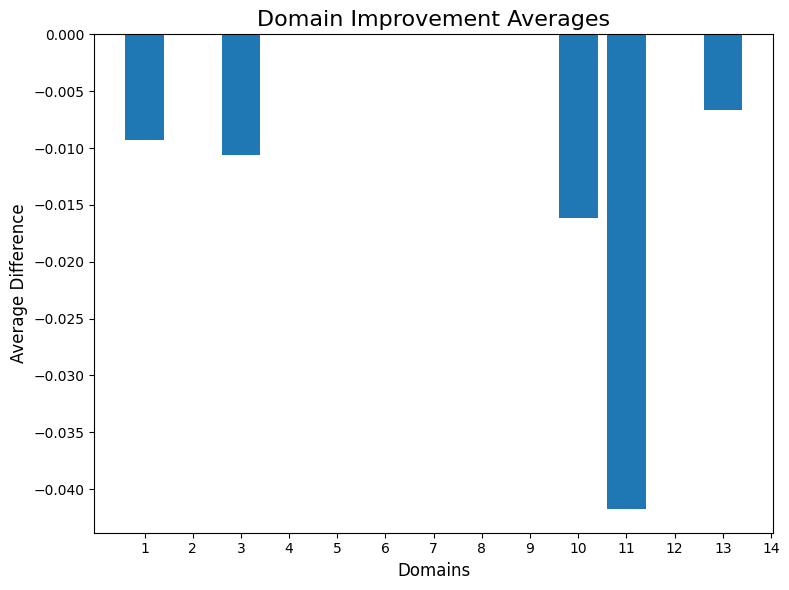

In [ ]:
## ground truth
diff = target.to_numpy() * train_data[encoding_columns].to_numpy() - train_data[score_columns].to_numpy() * train_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(train_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Ground Truth Training Data Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [62]:
target

,domain 1 target,domain 2 target,domain 3 target,domain 4 target,domain 5 target,domain 6 target,domain 7 target,domain 8 target,domain 9 target,domain 10 target,domain 11 target,domain 12 target,domain 13 target,domain 14 target
139190,0.429,0.00,0.813,0.214,0.050,0.000,0.000,0.00,0.00,0.443,0.88,0.307,0.224,0.813
90715,0.643,0.00,1.000,0.129,0.000,0.400,0.280,0.00,0.60,0.543,1.00,0.036,0.727,0.507
59543,0.429,0.90,0.960,0.257,0.140,0.600,0.470,0.00,0.35,0.000,0.00,0.093,0.642,1.000
64042,0.429,0.00,0.000,0.214,0.050,0.516,0.510,0.00,0.00,0.585,1.00,0.500,0.849,0.000
138300,0.357,0.00,0.867,0.228,0.080,0.000,0.000,0.00,0.00,0.350,1.00,0.279,0.515,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161659,0.414,0.23,1.000,0.000,0.000,0.000,0.000,0.00,0.08,0.564,0.72,0.286,0.503,0.000
106769,0.886,0.86,1.000,0.357,0.150,1.000,0.517,1.00,0.68,0.679,0.00,0.464,0.818,1.000
152351,0.443,0.00,0.000,0.000,0.000,0.000,0.000,0.00,0.00,0.625,1.00,0.000,0.000,0.000
124756,0.357,0.18,0.627,0.071,0.000,1.000,0.670,0.05,0.14,0.536,0.80,0.164,0.333,1.000


In [63]:
train_data = train_data.to_numpy()
target = target.to_numpy()

In [64]:
def create_missing_indicator(data):
    (l, w) = data.shape
    temp = np.zeros((l, w*2))
    for i in range(l):
        for d in range(w):
            p = data[i, d]
            # update output array
            if p == 0:
                # print("shouldn't be here")
                missing_ind = np.random.choice(2, 1)[0]
                temp[i, d*2] = missing_ind
                temp[i, d*2+1] = missing_ind
            else:
                temp[i, d*2] = p # score
                temp[i, d*2+1] = 1-p # 1-score
    return copy.deepcopy(temp)

In [65]:
train_data_scores = create_missing_indicator(train_data[:, -14:])
train_data = np.hstack((train_data[:, :14], train_data_scores))

In [66]:
train_data

array([[1.   , 0.   , 0.   , ..., 0.776, 0.813, 0.187],
       [1.   , 0.   , 0.   , ..., 0.273, 0.507, 0.493],
       [1.   , 0.   , 0.   , ..., 0.358, 1.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   , ..., 0.   , 1.   , 1.   ],
       [1.   , 0.   , 0.   , ..., 0.667, 1.   , 0.   ],
       [1.   , 0.   , 0.   , ..., 0.467, 0.   , 0.   ]])

In [67]:
train_data[0]

array([1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.429, 0.571, 0.   , 0.   ,
       0.813, 0.187, 0.214, 0.786, 0.05 , 0.95 , 0.   , 0.   , 0.   ,
       0.   , 1.   , 1.   , 0.   , 0.   , 0.443, 0.557, 0.88 , 0.12 ,
       0.307, 0.693, 0.224, 0.776, 0.813, 0.187])

Model

In [68]:
## input : 14 domain encodings + 14 domains (28 total features with missing indicator)
## output: 28 score (prediction for the scores after next domain)
class NN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 14
        
        self.model = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 3, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, 200),
            torch.nn.Sigmoid(),
            torch.nn.Linear(200, 100),
            torch.nn.Sigmoid(),
            torch.nn.Linear(100, n_domains)
        )

    def forward(self, x):
        return torch.clamp(self.model(x), min=0, max=1)

In [69]:
class customDataset(Dataset):
    def __init__(self, data, target):
        super().__init__()
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).float()

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        return self.data[index, :], self.target[index, :]

Training

In [70]:
def train_model(x_train, x_val,y_train, y_val, epochs, model, optimizer, loss_function):
    outputs = []
    losses = []
    val_losses = []
    w = 14 ## hardcoded

    data_set = customDataset(x_train, y_train)
    data_loader = DataLoader(data_set, batch_size=64, shuffle=True)

    for epoch in range(epochs):
        epoch_loss = []
        val_epoch_loss = []
        ## training
        model.train()
        for batch_x, batch_y in data_loader:
            # Output of Autoencoder
            reconstructed = model(batch_x)
            
            # Calculating the loss function
            loss = loss_function(reconstructed, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            epoch_loss.append(loss.item())

        losses.append(statistics.mean(epoch_loss))
        # outputs.append((epochs, batch_x, reconstructed))

        ## validation
        model.eval()
        with torch.no_grad():
            val_rs = x_val.reshape(-1, w * 3)
            val_t = torch.from_numpy(val_rs)
            val_t = val_t.clone().detach().type(torch.float32)
            answer = model(val_t)
            val_loss = loss_function(answer, torch.from_numpy(y_val.reshape(-1, w)).type(torch.float32))
        val_losses.append(val_loss)
    return losses, val_losses, outputs, model

In [71]:
num_runs = 1

In [72]:
losses_2d = []
val_losses_2d = []
for i in range(num_runs):
    model = NN()
    epochs = 10
    lr = 0.005

    # Validation using MSE Loss function
    loss_function = torch.nn.MSELoss()
    
    # Using an Adam Optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                                lr = lr)
    
    x_train, x_val, y_train, y_val = train_test_split(train_data, target, test_size=0.50)

    model.eval()
    with torch.no_grad():
        predictions = model(torch.from_numpy(x_train).float())
        zero_loss = loss_function(predictions, torch.from_numpy(y_train).float())

        predictions = model(torch.from_numpy(x_val).float())
        zero_loss_val = loss_function(predictions, torch.from_numpy(y_val).float())
    
    losses, val_losses, outputs, model = train_model(x_train, x_val, y_train, y_val, epochs, model, optimizer, loss_function)
    losses = [zero_loss.item()] + losses
    val_losses = [zero_loss_val.item()] + val_losses
    
    losses_2d.append(losses)
    val_losses_2d.append(val_losses)

In [73]:
def plot_mean_and_std(data, color_choice="blue", setting=""):
    """
    Plots the mean and standard deviation across multiple lists of data.
    
    Parameters:
    - data (list of lists): A list where each element is a list of numbers.
    
    The function will compute the mean and standard deviation at each point
    across the lists and plot these as a line for the mean and shading for the
    standard deviation.
    """
    # Convert data to a NumPy array for easier manipulation
    data_array = np.array(data)
    
    # Calculate mean and standard deviation
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    # print(means, stds)
    
    # Create the x-axis values
    x_values = np.arange(len(means))
    
    # Plotting
    plt.plot(x_values, means, label='%s Mean' % setting, color=color_choice)  # Mean line
    plt.fill_between(x_values, means - stds, means + stds, color=color_choice, alpha=0.2, label='%s Standard Deviation' % setting)
    
    plt.title('Mean and Standard Deviation Plot of %s' % setting)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

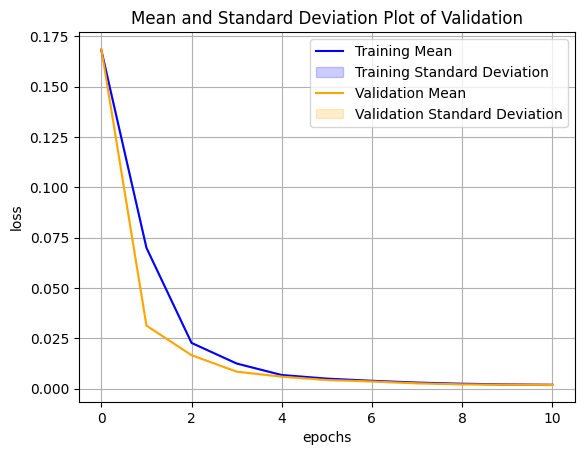

In [74]:
# Defining the Plot Style

# Plotting
if num_runs != 0:
    with torch.no_grad():
        plot_mean_and_std(losses_2d, "blue", "Training")
        plot_mean_and_std(val_losses_2d, "orange", "Validation")

### Quantitative (overall baseline vs prediction view)
- compare our prediction to baseline in test set in a quantitative manner (rather than looking at an individual heatmap)

In [75]:
if num_runs == 0: ## no training, take from previously saved model
    model = NN()
    model = torch.load("model/next_step_3.pt")

In [76]:
## take in dataframe, return known domain average for prediction, modified from baseline quant 11/04/2024
def known_domain_average(data : pd.DataFrame):
    """
    Imputes missing values (NaN) in a DataFrame with the average of the non-missing values in the same row.

    Parameters:
    - data (pd.DataFrame): The DataFrame to impute.

    Returns:
    - pd.DataFrame: The DataFrame with missing values imputed.
    """
    assert(data.shape[1] == 14 * 2) ## make sure that the dataframe is the right shape with encoding, current, and target

    # separate encoding, scores, and target (which we dont need so ignored in here)
    encoding = data.iloc[:, :14].copy()
    data_ = data.iloc[:, 14:28].copy()

    # Replace '0' with NaN to handle them as missing values
    data_ = data.replace(0, np.nan)
    # initialize the list we are going to use to store all known domain average
    known_domain_average_lst = []

    # Iterate over each row
    for index, row in data_.iterrows():
        # Calculate the mean of the non-NaN values in the row
        mean_value = row.mean()
        # if there are no known domains, we say known domain average is 0
        if np.isnan(mean_value):
            mean_value = 0
        # append the average onto the list
        known_domain_average_lst.append(mean_value)
        # in the encoding df, replace na with 
        encoding.loc[index] = encoding.loc[index].replace(1, mean_value)
    
    return encoding

In [77]:
def get_accuracy(y_pred, y_true, n, fn : str):
    diff = y_pred - y_true
    if fn == "mse":
        return np.sum(np.power(diff, 2)) / n
    elif fn == "mae":
        return np.sum(np.abs(diff)) / n

In [78]:
# get predictions from the model
def predict(data, model):
    model.eval()
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data_t).clone().detach().numpy()

In [79]:
accuracy_list_prediction_sq = []
accuracy_list_knownimputation_sq = []
accuracy_list_prediction_abs = []
accuracy_list_knownimputation_abs = []

for masked_number in range(14):
    # Count the number of rows with exactly 'masked_number' missing values (indicated by 0)
    masked_rows = (test_data[score_columns] == 0).sum(axis=1) == masked_number
    masked_test_data = test_data[masked_rows]
    
    if masked_test_data.shape[0] == 0:
        # If no rows have the required number of missing values, append NaN and continue
        accuracy_list_prediction_abs.append(np.nan)
        accuracy_list_knownimputation_abs.append(np.nan)
        accuracy_list_prediction_sq.append(np.nan)
        accuracy_list_knownimputation_sq.append(np.nan)
        continue

    # known domain average prediction for the next domains
    baseline_prediction = known_domain_average(masked_test_data[encoding_columns + score_columns]).to_numpy()

    # predict
    masked_test_data_ = copy.deepcopy(masked_test_data[encoding_columns + score_columns])
    masked_test_data_ = masked_test_data_.to_numpy()
    test_data_scores = create_missing_indicator(masked_test_data_[:, -14:])
    masked_test_data_ = np.hstack((masked_test_data_[:, :14], test_data_scores))
    model_prediction = predict(masked_test_data_, model)
    model_prediction = np.multiply(model_prediction, masked_test_data[encoding_columns].to_numpy()) # element wise multiply the two so we have the same form as baseline prediction
    # we only have the values we are predicting in the matrix, everything else is 0

    # get accuracy (abs)
    original = masked_test_data[target_columns].copy().to_numpy() # ground truth
    original = np.multiply(original, masked_test_data[encoding_columns].copy().to_numpy()) # element wise multiply the two so we only have the scores we care about predicting
    assert original.shape == model_prediction.shape and original.shape == baseline_prediction.shape
    n_predicting = np.sum(masked_test_data[encoding_columns].copy().to_numpy())

    accuracy_list_prediction_abs.append(get_accuracy(model_prediction, original, n_predicting, "mae"))
    accuracy_list_knownimputation_abs.append(get_accuracy(baseline_prediction, original, n_predicting, "mae"))

    # get accuracy (sq)
    accuracy_list_prediction_sq.append(get_accuracy(model_prediction, original, n_predicting, "mse"))
    accuracy_list_knownimputation_sq.append(get_accuracy(baseline_prediction, original, n_predicting, "mse"))

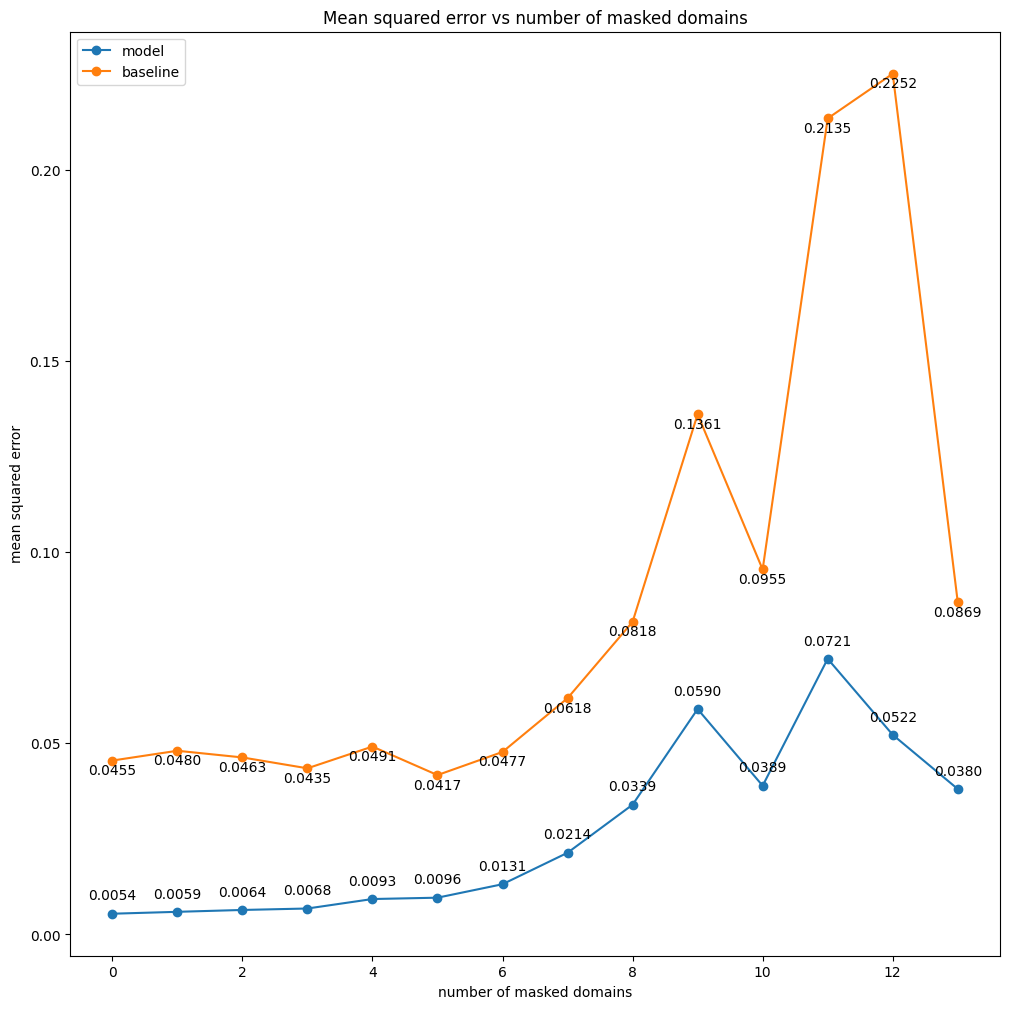

In [80]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_sq, yerr=error_prediction_sq, label="model", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_sq, yerr=error_imputation_sq, label="baseline")

x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_sq, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_sq, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_sq, accuracy_list_knownimputation_sq):
    offset = 10

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center



plt.xlabel("number of masked domains")
plt.ylabel("mean squared error")
plt.title("Mean squared error vs number of masked domains")
plt.legend()

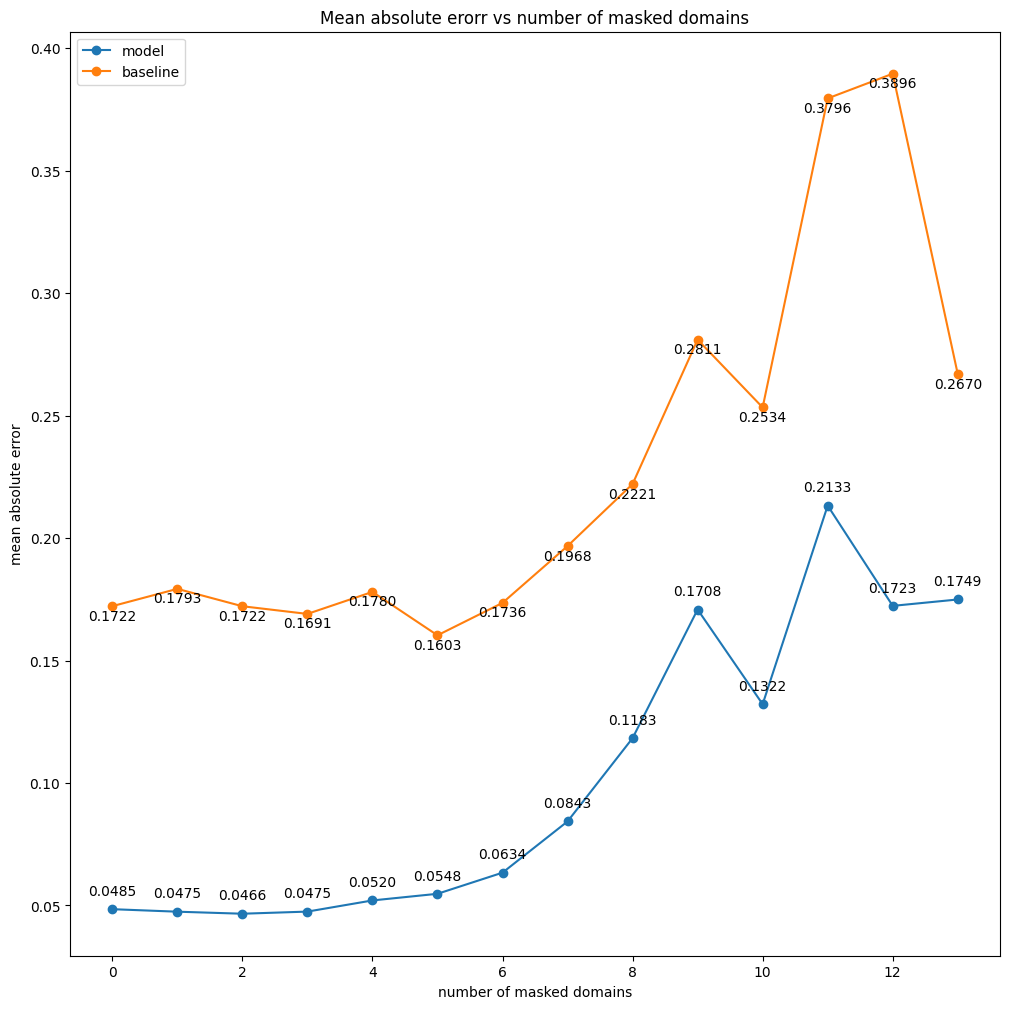

In [81]:
fig = plt.figure(figsize=(12, 12))
# plt.errorbar(range(0, 14), accuracy_list_prediction_abs, yerr=error_prediction_abs, label="prediction", linewidth=3)
# plt.errorbar(range(0, 14), accuracy_list_imputation_abs, yerr=error_imputation_abs, label="imputation")
x_values = range(0, 14)

plt.plot(x_values, accuracy_list_prediction_abs, label="model", marker="o")
plt.plot(x_values, accuracy_list_knownimputation_abs, label="baseline", marker="o")

for x, y1, y2 in zip(x_values, accuracy_list_prediction_abs, accuracy_list_knownimputation_abs):

    label = "{:.4f}".format(y1)
    plt.annotate(label, # this is the text
                (x,y1), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    
    label = "{:.4f}".format(y2)
    plt.annotate(label, # this is the text
                (x,y2), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center
    

plt.xlabel("number of masked domains")
plt.ylabel("mean absolute error")
plt.title("Mean absolute erorr vs number of masked domains")
plt.legend()

### Visualization
- visualize individual patient's trajectory (ground truth vs prediction vs imputation?)
- look at overall quantitative picture

In [82]:
column_names = ["domain %d score" % i for i in range(1, 15)]
column_rename_dict = {}
for i in range(len(column_names)):
    column_rename_dict[column_names[i]] = i + 1

In [83]:
# takes in a matrix, returns a list mean along rows
def get_score(data):
    return np.mean(data, axis=1)

In [84]:
# get ground truth scores (overall)
GT_scores = get_score(case_study_data[column_names].to_numpy())

In [85]:
# get prediction scores
model.eval()
with torch.no_grad():
    test_data_case = case_study_data[encoding_columns + score_columns].to_numpy()
    test_data_scores = create_missing_indicator(test_data_case[:, -14:])
    test_data_case = np.hstack((test_data_case[:, :14], test_data_scores))
    predictions = model(torch.from_numpy(test_data_case).type(torch.float32)).detach().numpy()

In [86]:
n_missing = np.sum(case_study_data[encoding_columns].to_numpy())
target_ = np.multiply(case_study_data[target_columns].to_numpy(), case_study_data[encoding_columns].to_numpy()) # only the targets we want to predict
prediction_ = np.multiply(predictions, case_study_data[encoding_columns].to_numpy()) # only the scores we want to predict
mse_ = np.divide(np.sum(np.abs(target_ - prediction_)), n_missing)

In [87]:
# mask for which columns we are trying to predict
mask = case_study_data[encoding_columns].to_numpy()

In [88]:
prediction_only = pd.DataFrame(mask * predictions, columns=column_names)
target_only = pd.DataFrame(mask * case_study_data[target_columns].to_numpy(), columns=column_names)

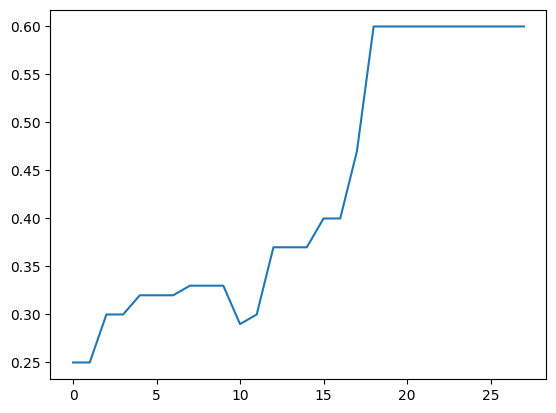

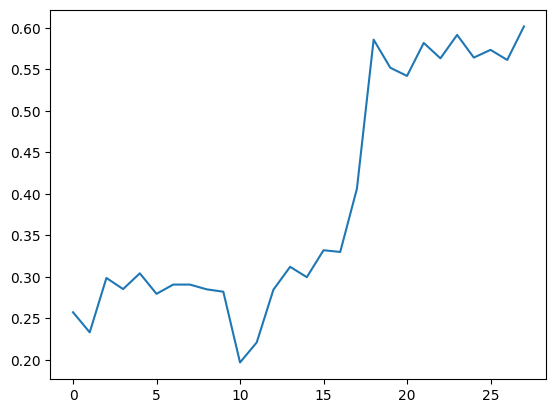

In [ ]:
## plot specific domain progression
plt.figure()
plt.plot(range(case_study_data.shape[0]), case_study_data["domain 1 target"])
plt.show()
plt.figure()
plt.plot(range(case_study_data.shape[0]), predictions[:, 0])
plt.show()

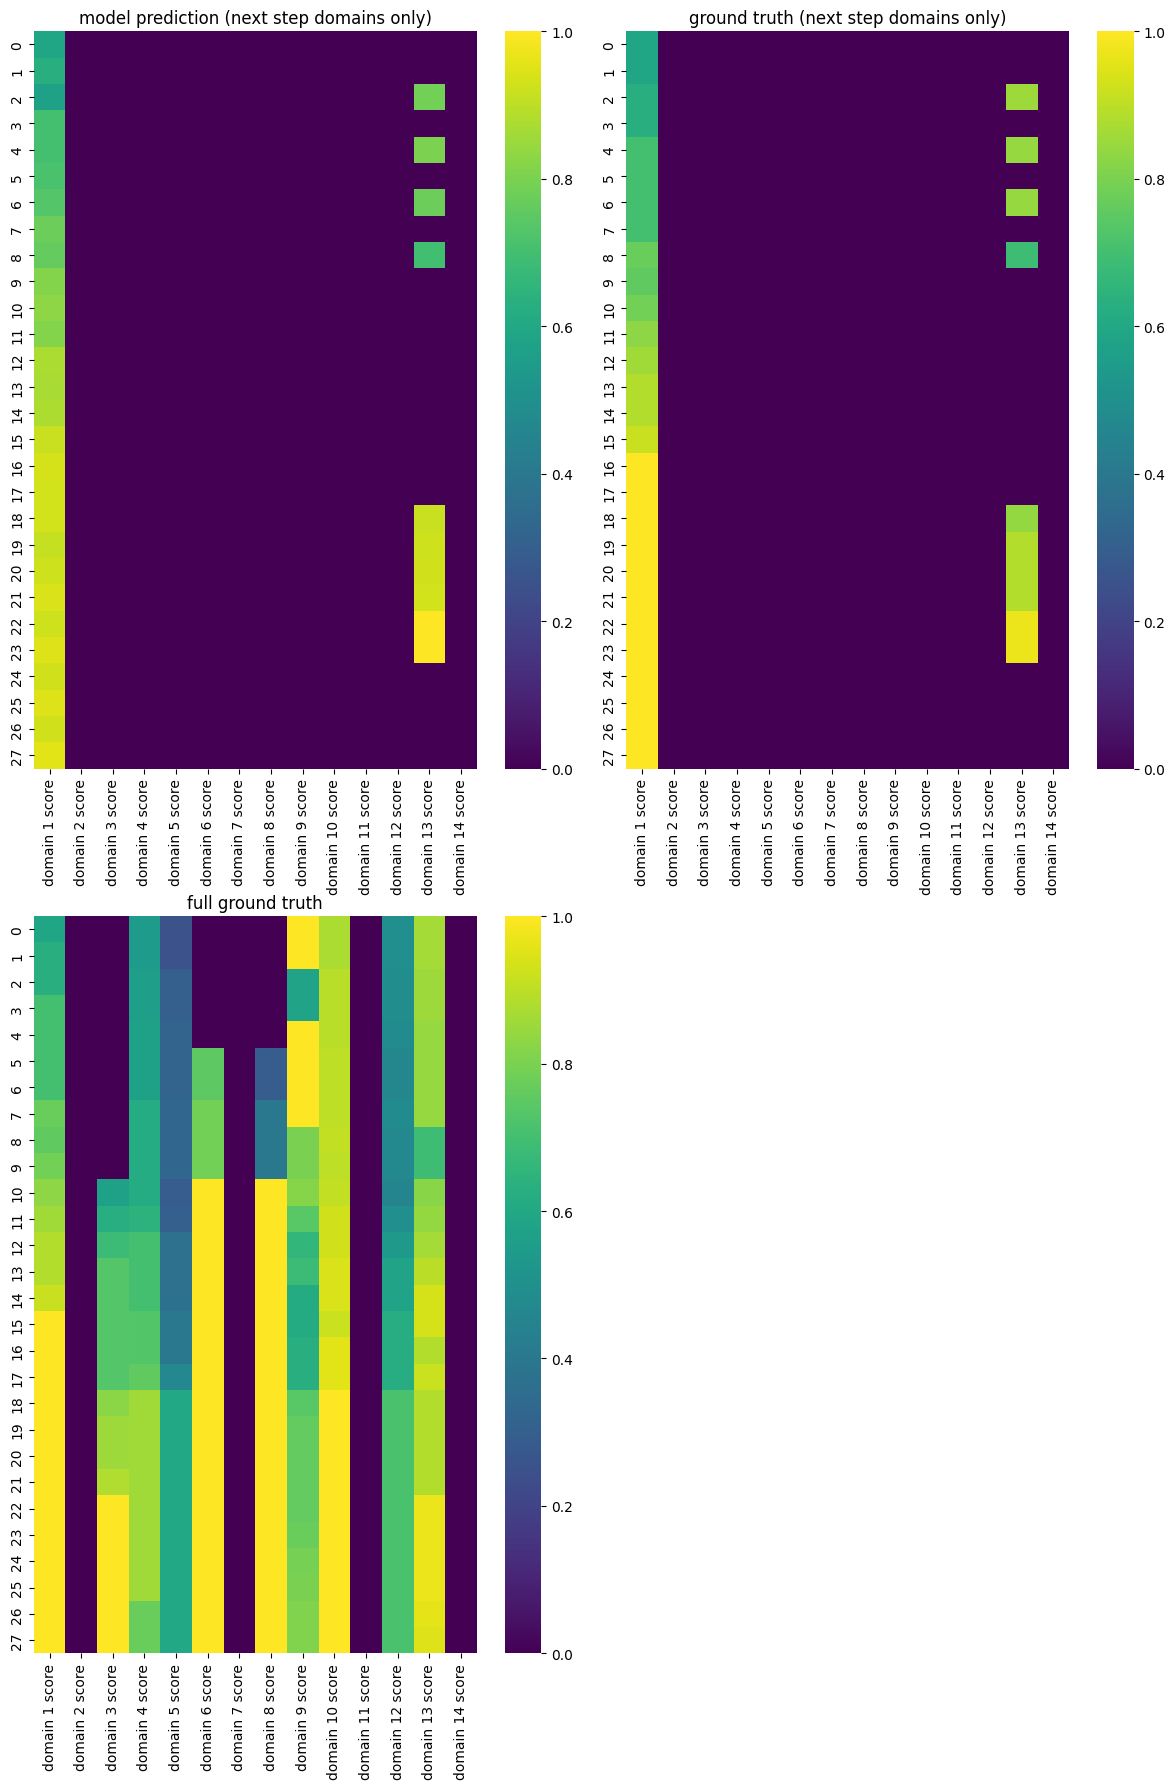

In [90]:
fig = plt.figure(figsize=(12, 18))
vmin = 0
vmax = 1

plt.subplot(2, 2, 1)
sns.heatmap(prediction_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("model prediction (next step domains only)")

plt.subplot(2, 2, 2)
sns.heatmap(target_only, cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("ground truth (next step domains only)")

plt.subplot(2, 2, 3)
sns.heatmap(case_study_data[score_columns], cmap="viridis", cbar=True, vmin=vmin, vmax=vmax)
plt.title("full ground truth")

fig.tight_layout()
fig.subplots_adjust(hspace=0.2)

In [91]:
np.unique(df[df.patient_id == pid]["domain_ids"])

array(['1', '1,13', '10', '12', '12,13', '13', '3,12', '3,13', '4', '4,5',
       '5', '6,8', '7', '8', '9'], dtype=object)

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/2381277288.py:6: RuntimeWarning: invalid value encountered in divide
  column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)


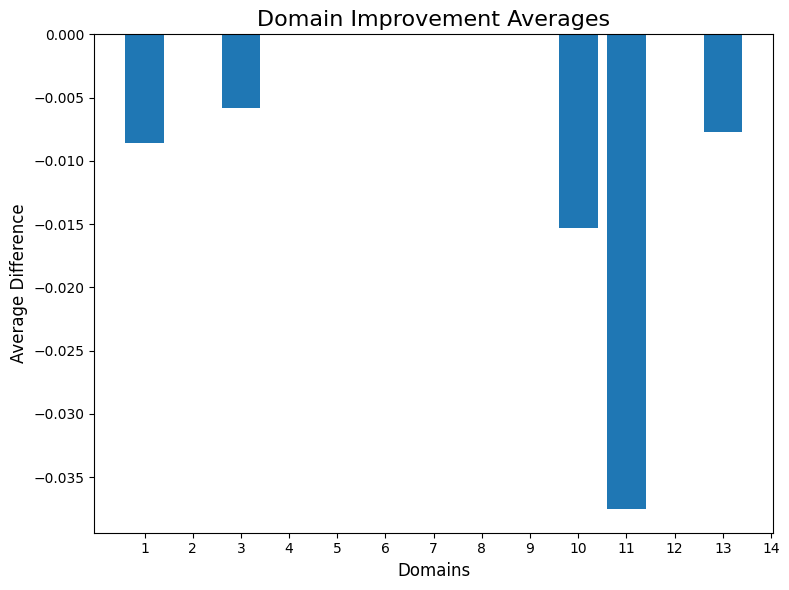

In [ ]:
## ground truth
diff = test_data[target_columns].to_numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()


# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Test Data Ground Truth Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [94]:
test_data_input = test_data[encoding_columns + score_columns].copy().to_numpy()
test_data_scores = create_missing_indicator(test_data_input[:, -14:])
test_data_input = np.hstack((test_data_input[:, :14], test_data_scores))

In [95]:
predictions = model(torch.from_numpy(test_data_input).float())

In [96]:
predictions

tensor([[0.1140, 0.2929, 0.3931,  ..., 0.2019, 0.1634, 0.0000],
        [0.4753, 1.0000, 0.7962,  ..., 0.3096, 0.5069, 0.6760],
        [0.1690, 0.0000, 0.0000,  ..., 0.1652, 0.1657, 0.0000],
        ...,
        [0.2783, 0.1418, 0.7872,  ..., 0.1653, 0.2739, 0.0000],
        [0.3595, 0.4321, 1.0000,  ..., 0.4054, 0.9629, 0.6704],
        [0.3152, 0.3995, 1.0000,  ..., 0.4364, 0.2892, 0.3157]],
       grad_fn=<ClampBackward1>)

In [97]:
diff = predictions.detach().numpy() * test_data[encoding_columns].to_numpy() - test_data[score_columns].to_numpy() * test_data[encoding_columns].to_numpy()

In [98]:
np.sum(test_data[encoding_columns].to_numpy(), axis=0)

array([40771.,     0.,   324.,     0.,     0.,     0.,     0.,     0.,
           0.,  7587.,  7587.,     0.,  5129.,     0.])

In [99]:
diff

array([[ 0.11402457,  0.        ,  0.        , ...,  0.        ,
        -0.02457695,  0.        ],
       [-0.02468973,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00995407,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.03569253,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.02651563,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01523484,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/3705821173.py:2: RuntimeWarning: invalid value encountered in divide
  column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)


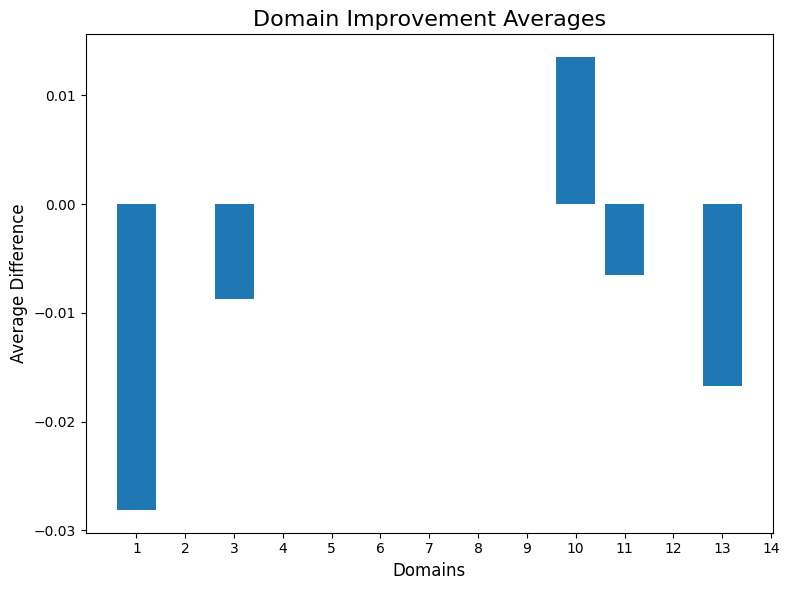

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(diff, axis=0) / np.sum(test_data[encoding_columns].to_numpy(), axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("All Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [101]:
diff.shape

(40771, 14)

In [102]:
repeat_test = test_data[repeat_columns].to_numpy().copy().flatten()
repeat_test.shape

(40771,)

In [103]:
repeats_diff = diff[repeat_test == 1]
non_repeats_diff = diff[repeat_test == 0]

In [104]:
repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 1]
non_repeats_n = test_data[encoding_columns].to_numpy()[repeat_test == 0]

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/546825816.py:2: RuntimeWarning: invalid value encountered in divide
  column_averages = np.sum(repeats_diff, axis=0) / np.sum(repeats_n, axis=0)


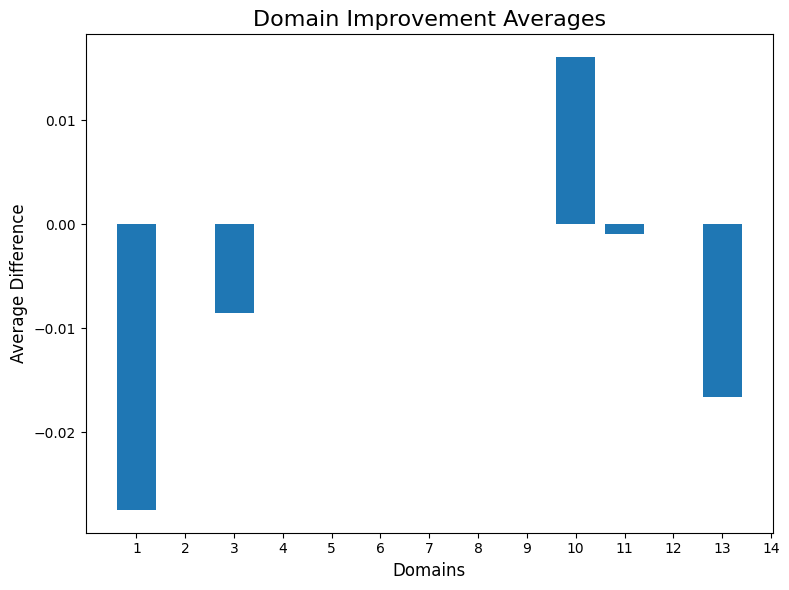

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(repeats_diff, axis=0) / np.sum(repeats_n, axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

/var/folders/vv/6vndbrvd7r1gc7xq3qqx8tfh0000gq/T/ipykernel_29661/3126657943.py:2: RuntimeWarning: invalid value encountered in divide
  column_averages = np.sum(non_repeats_diff, axis=0) / np.sum(non_repeats_n, axis=0)


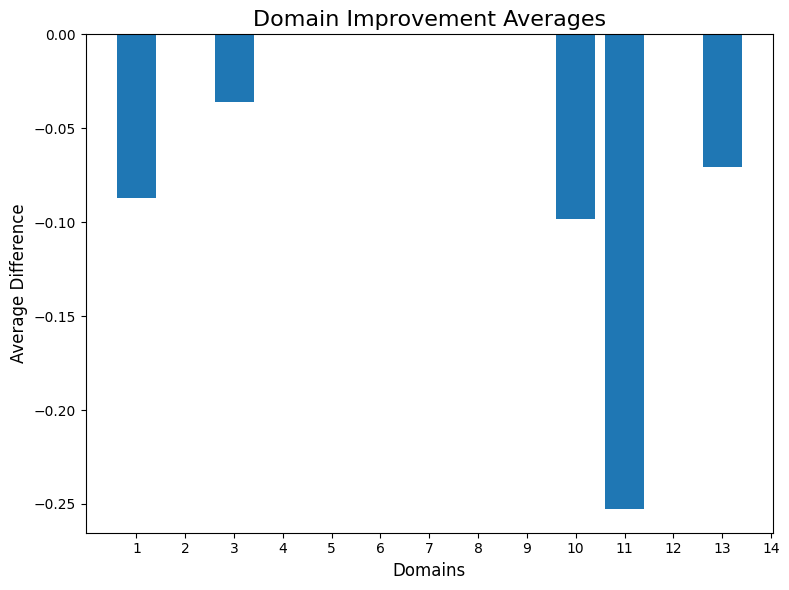

In [ ]:
# Calculate column-wise averages
column_averages = np.sum(non_repeats_diff, axis=0) / np.sum(non_repeats_n, axis=0)

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(len(column_averages)), column_averages, tick_label=[f"{i+1}" for i in range(len(column_averages))])

# Add labels and title
plt.xlabel("Domains", fontsize=12)
plt.ylabel("Average Difference", fontsize=12)
plt.title("Non Repeat Prediction Domain Improvement Averages", fontsize=16)
plt.tight_layout()

# Show the plot
plt.show()

In [107]:
# store model as 
# torch.save(model, "model/next_step_5.pt")